In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
data_source = "./datasets/iris/iris.data"
data = pd.read_csv(data_source, 
                   delimiter=',', 
                   names=['sepal_length',
                          'sepal_width',
                          'petal_length',
                          'petal_width','answer'],
                   header=None)
data.head(10)
X = data[['sepal_length', 'sepal_width', 'petal_length', 'petal_width']]
y = data['answer']

In [3]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Подмножества для hold-out
X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size=0.3, random_state=12)

# Обучение модели
tree = DecisionTreeClassifier(max_depth=5, 
                              random_state=21, 
                              max_features=2)
tree.fit(X_train, y_train)

# Получение оценки hold-out
tree_pred = tree.predict(X_holdout)
accur = accuracy_score(y_holdout, tree_pred)
print(accur)

0.9777777777777777


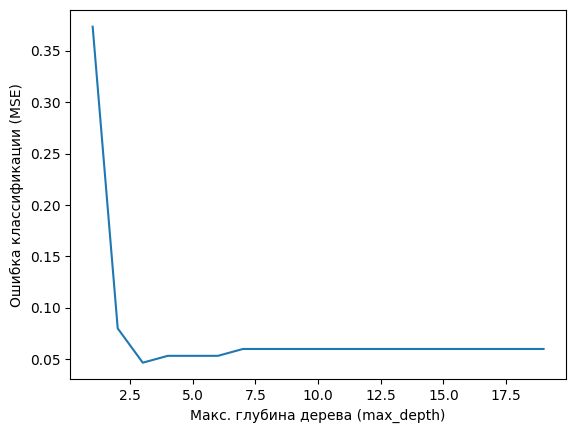

Оптимальные значения max_depth:  [3]


In [4]:
from sklearn.model_selection import cross_val_score

# Значения параметра max_depth
d_list = list(range(1,20))
# Пустой список для хранения значений точности
cv_scores = []
# В цикле проходим все значения K
for d in d_list:
    tree = DecisionTreeClassifier(max_depth=d, 
                                  random_state=21, 
                                  max_features=2)
    scores = cross_val_score(tree, X, y, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())

# Вычисляем ошибку (misclassification error)
MSE = [1-x for x in cv_scores]

# Строим график
plt.plot(d_list, MSE)
plt.xlabel('Макс. глубина дерева (max_depth)');
plt.ylabel('Ошибка классификации (MSE)')
plt.show()

# Ищем минимум
d_min = min(MSE)

# Пробуем найти прочие минимумы (если их несколько)
all_d_min = []
for i in range(len(MSE)):
    if MSE[i] <= d_min:
        all_d_min.append(d_list[i])

# печатаем все K, оптимальные для модели
print('Оптимальные значения max_depth: ', all_d_min)

In [5]:
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn import tree

dtc = DecisionTreeClassifier(max_depth=10, random_state=21, max_features=2)

tree_params = { 'max_depth': range(1,20), 'max_features': range(1,4) }
tree_grid = GridSearchCV(dtc, tree_params, cv=10, verbose=True, n_jobs=-1)
tree_grid.fit(X, y)

print('\n')
print('Лучшее сочетание параметров: ', tree_grid.best_params_)
print('Лучшие баллы cross validation: ', tree_grid.best_score_)

Fitting 10 folds for each of 57 candidates, totalling 570 fits


Лучшее сочетание параметров:  {'max_depth': 2, 'max_features': 3}
Лучшие баллы cross validation:  0.9533333333333334


In [6]:
from sklearn.tree import export_graphviz
# Генерируем графическое представление дерева
tree.export_graphviz(tree_grid.best_estimator_, 
                     feature_names=X.columns,
                     class_names=y.unique(),
                     out_file='./img/iris_tree.dot',  
                     filled=True, rounded=True);

In [14]:
# %apt-get install graphviz
import os
# %pip install graphviz
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin/'

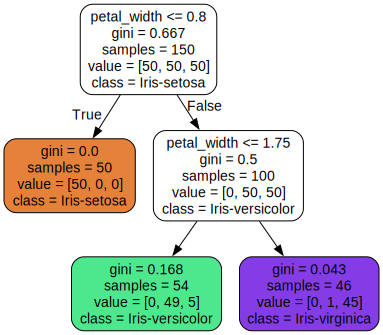

In [15]:
import graphviz

with open('./img/iris_tree.dot') as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

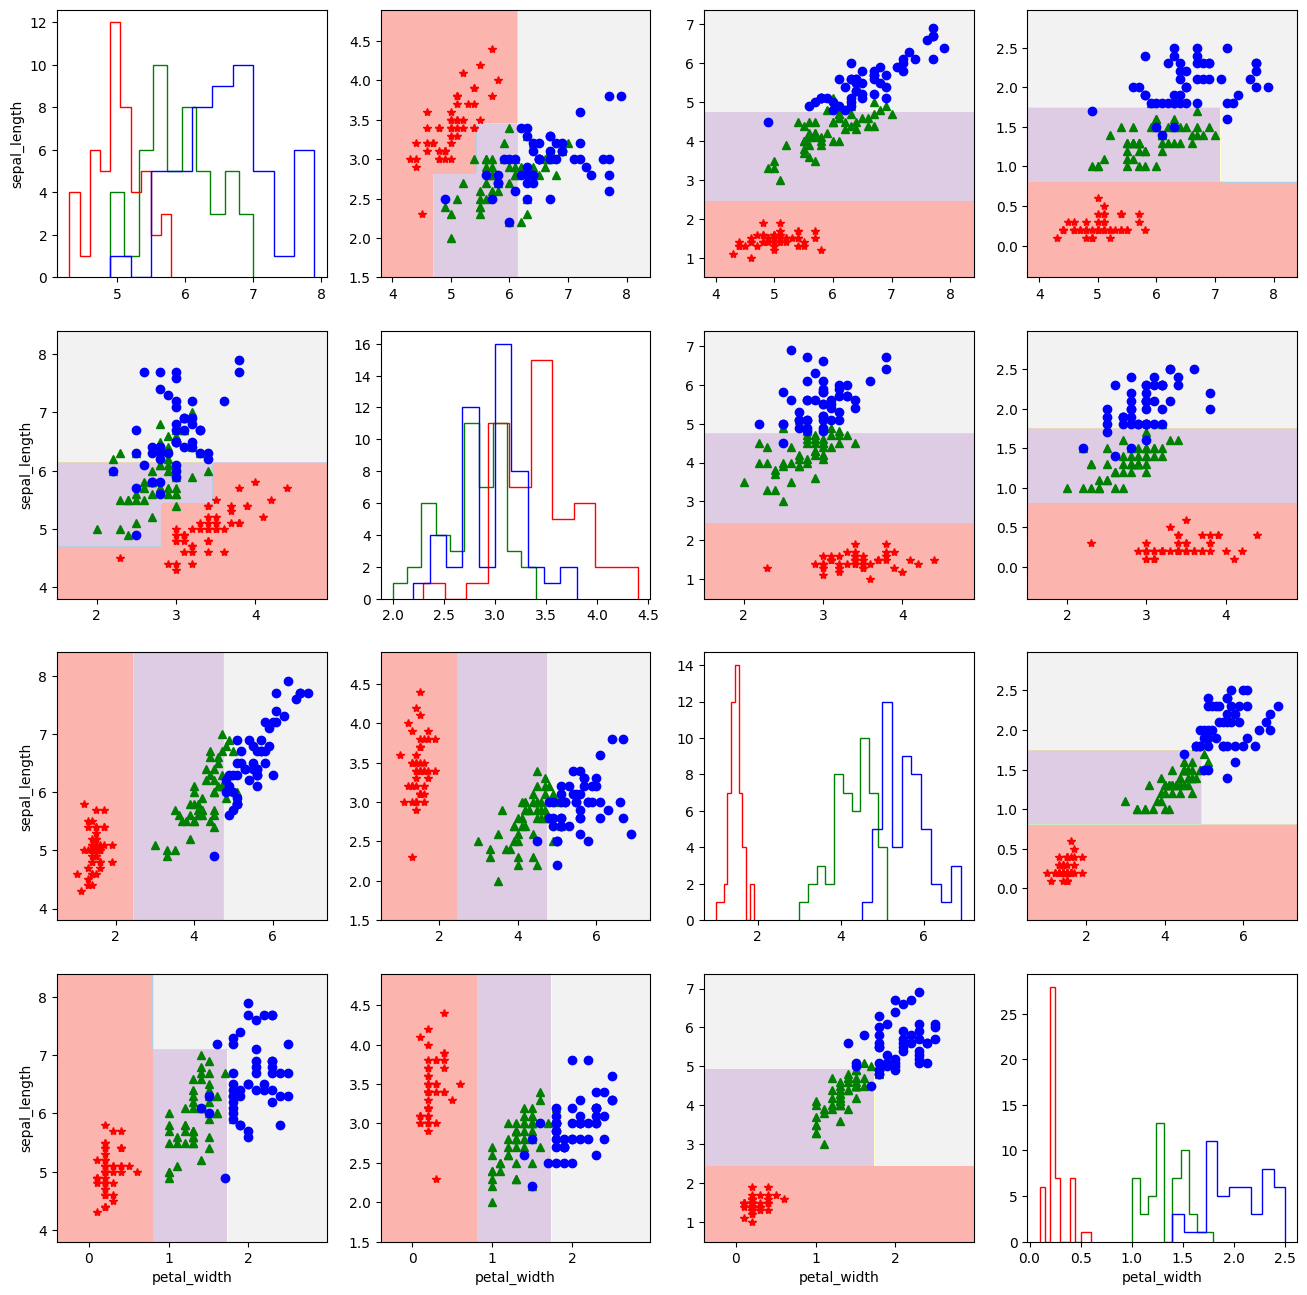

In [16]:
plot_markers = ['r*', 'g^', 'bo']
answers = y.unique()

# Создаем подграфики для каждой пары признаков
f, places = plt.subplots(4, 4, figsize=(16,16))

fmin = X.min()-0.5
fmax = X.max()+0.5
plot_step = 0.02  

# Обходим все subplot
for i in range(0,4):
    for j in range(0,4):

        # Строим решающие границы 
        if(i != j):
            xx, yy = np.meshgrid(np.arange(fmin[i], fmax[i], plot_step),
                               np.arange(fmin[j], fmax[j], plot_step))
            model = DecisionTreeClassifier(max_depth=3, random_state=21, max_features=2)
            model.fit(X.iloc[:, [i,j]].values, y)
            p = model.predict(np.c_[xx.ravel(), yy.ravel()])
            p = p.reshape(xx.shape)
            p[p==answers[0]] = 0
            p[p==answers[1]] = 1
            p[p==answers[2]] = 2
            xx = xx.astype(np.float32)
            yy = yy.astype(np.float32)
            p = p.astype(np.float32)
            places[i,j].contourf(xx, yy, p, cmap='Pastel1') 
      
        # Обход всех классов
        for id_answer in range(len(answers)):
            idx = np.where(y == answers[id_answer])
            if i==j:
                places[i, j].hist(X.iloc[idx].iloc[:,i],
                                  color=plot_markers[id_answer][0],
                                 histtype = 'step')
            else:
                places[i, j].plot(X.iloc[idx].iloc[:,i], X.iloc[idx].iloc[:,j], 
                                  plot_markers[id_answer], 
                                  label=answers[id_answer], markersize=6)
        
        if j==0:
            places[i, j].set_ylabel(X.columns[j])
        
        if i==3:
            places[i, j].set_xlabel(X.columns[i])
        

In [17]:
# Построим модель для оптимального дерева
# max_features = 2, max_depth = 3

dtc = DecisionTreeClassifier(max_depth=3, 
                             random_state=21, 
                             max_features=2)
dtc.fit(X.values, y.values)


# Использование классификатора
# Объявление признаков объекта

sepal_length = float(input('Введите длину чашелистика: '))
sepal_width = float(input('Введите ширину чашелистика: '))
petal_length = float(input('Введите длину лепестка: '))
petal_width = float(input('Введите ширину лепестка: '))
X_new = np.array([[sepal_length, sepal_width, petal_length, petal_width]])

# Получение ответа для нового объекта
target = dtc.predict(X_new)[0]


print('\nДанный цветок относится к виду: ',target)

Введите длину чашелистика:  12
Введите ширину чашелистика:  4
Введите длину лепестка:  2
Введите ширину лепестка:  24



Данный цветок относится к виду:  Iris-virginica
